In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

IMAGE_DIR = "../data/images/train"

files = os.listdir(IMAGE_DIR)[:100]

sizes = []
for f in files:
    img = Image.open(os.path.join(IMAGE_DIR, f))
    sizes.append(img.size)

sizes[:5]


[(445, 671), (445, 671), (445, 671), (444, 671), (442, 672)]

### RGB Histogram Analysis

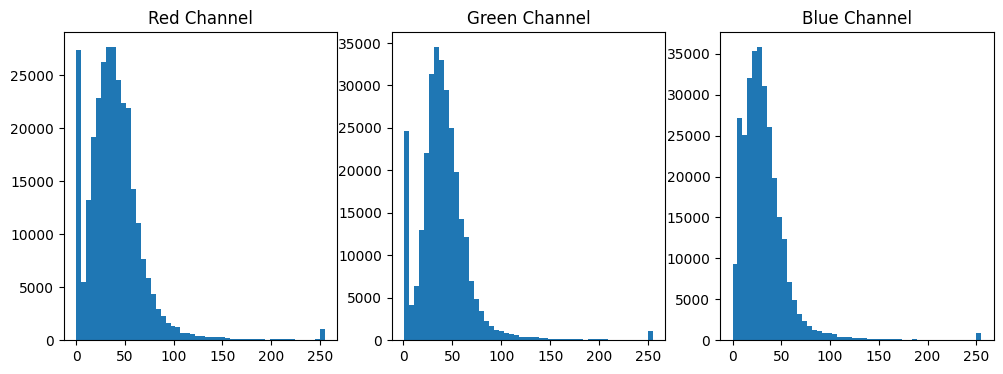

In [2]:
img = np.array(Image.open(os.path.join(IMAGE_DIR, files[0])))

plt.figure(figsize=(12,4))
for i, c in enumerate(['Red','Green','Blue']):
    plt.subplot(1,3,i+1)
    plt.hist(img[:,:,i].flatten(), bins=50)
    plt.title(f'{c} Channel')
plt.show()


### Deliverable explanation

Green channel correlates with vegetation

Blue highlights water bodies

Urban areas show higher grayscale uniformity

### Visual vs Price Correlation

In [3]:
import pandas as pd

df = pd.read_csv("../data/raw/train(1).csv")
print(df.shape)
print(df.columns)

sample = df.sample(6)

from PIL import Image
import matplotlib.pyplot as plt

import os

IMAGE_DIR = "../data/images/train"

id_to_image = {}

for fname in os.listdir(IMAGE_DIR):
    if fname.endswith(".png"):
        prop_id = fname.split("_")[0]   # 👈 extract ID
        id_to_image[prop_id] = fname

print("Images found:", len(id_to_image))



(16209, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
Images found: 16110


In [4]:
import pandas as pd

df = pd.read_csv("../data/raw/train(1).csv")
df["id_str"] = df["id"].astype(str)

df_available = df[df["id_str"].isin(id_to_image.keys())]

print("Rows with images:", df_available.shape)


Rows with images: (16209, 22)


In [5]:
sample = df_available.sample(min(6, len(df_available)))


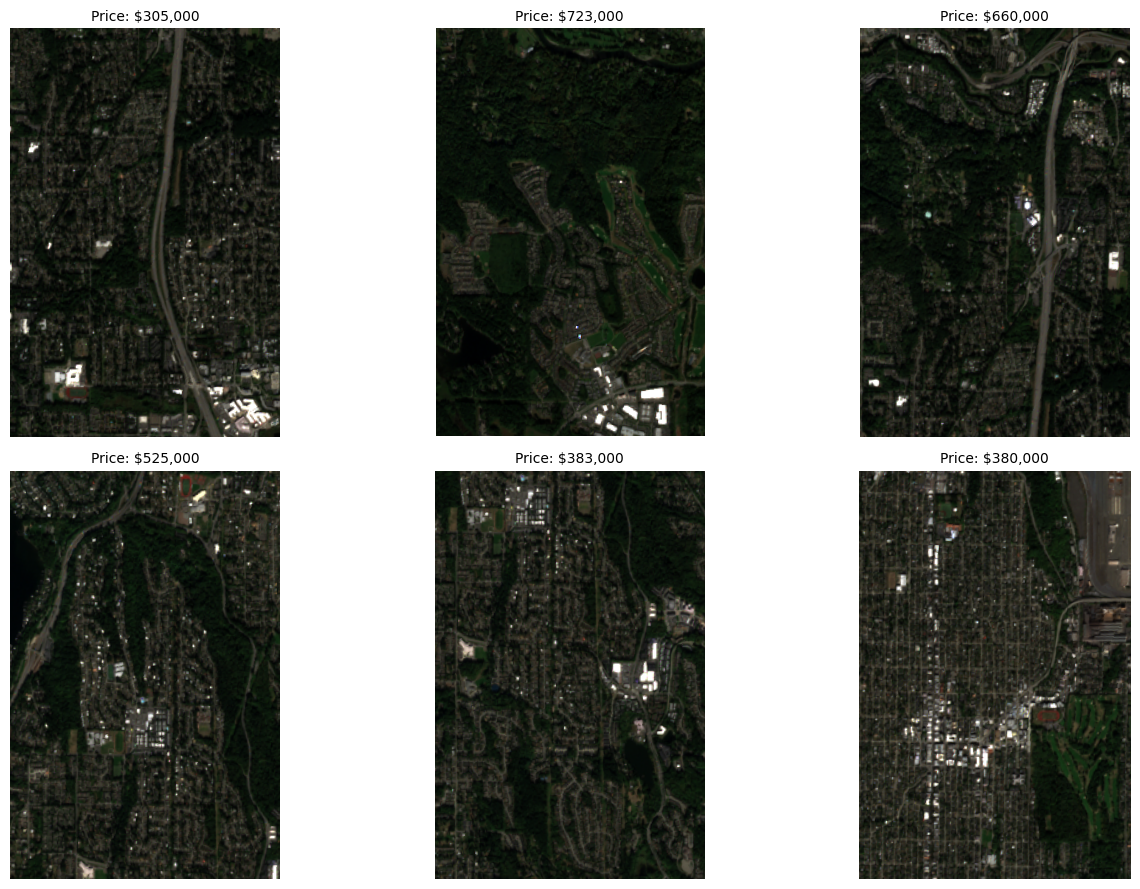

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import os

plt.figure(figsize=(14,9))

for i, (_, row) in enumerate(sample.iterrows()):
    img_file = id_to_image[row["id_str"]]
    img_path = os.path.join(IMAGE_DIR, img_file)

    img = Image.open(img_path)

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Price: ${row['price']:,}", fontsize=10)

plt.tight_layout()
plt.show()


### Cheap vs Expensive Properties — Satellite Image Comparison

To understand whether satellite imagery provides useful signals for house price prediction,
we visually compare satellite images of low-priced and high-priced properties.

This analysis helps validate the hypothesis that environmental and neighborhood features
(e.g., greenery, density, water proximity) contribute to property valuation.


In [7]:
cheap = df.sort_values("price").head(3)
expensive = df.sort_values("price", ascending=False).head(3)

compare_df = pd.concat([cheap, expensive])


In [8]:
print(compare_df.shape)
compare_df[["id", "price"]]


(6, 22)


,id,price
3656,3421079032,75000
3789,8658300340,80000
16074,3028200080,81000
4962,6762700020,7700000
1499,9808700762,7062500
2115,9208900037,6885000


In [9]:
for i, row in compare_df.iterrows():
    img_id = str(int(row["id"]))
    img_path = os.path.join(IMAGE_DIR, f"{img_id}.png")
    print(img_path, os.path.exists(img_path))


../data/images/train/3421079032.png False
../data/images/train/8658300340.png False
../data/images/train/3028200080.png False
../data/images/train/6762700020.png False
../data/images/train/9808700762.png False
../data/images/train/9208900037.png False


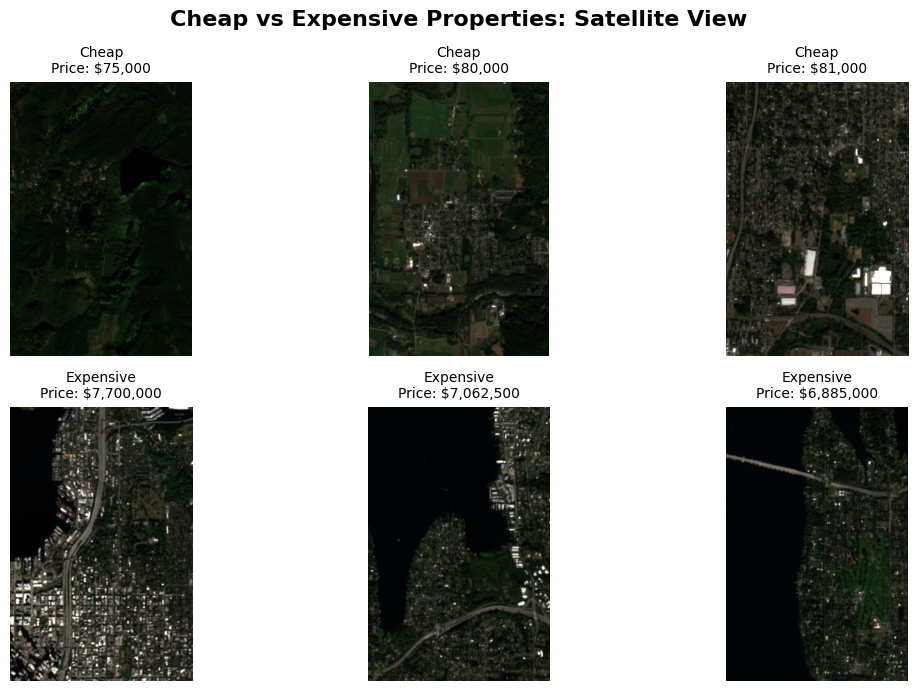

In [10]:
plt.figure(figsize=(12, 7))

for i, (_, row) in enumerate(compare_df.iterrows()):
    img_file = id_to_image.get(str(int(row["id"])))  # convert id to string
    if img_file is None:
        print(f"⚠️ Image not found for ID {row['id']}")
        continue

    img_path = os.path.join(IMAGE_DIR, img_file)
    if not os.path.exists(img_path):
        print(f"⚠️ File missing at path {img_path}")
        continue

    img = Image.open(img_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")

    label = "Cheap" if i < 3 else "Expensive"
    plt.title(f"{label}\nPrice: ${row['price']:,}", fontsize=10)

plt.suptitle(
    "Cheap vs Expensive Properties: Satellite View",
    fontsize=16,
    fontweight="bold"
)

plt.tight_layout()
plt.show()


In [11]:
plt.figtext(
    0.5, 0.01,
    "Cheap homes show denser layouts and limited greenery; expensive homes often show larger plots and natural features.",
    ha="center",
    fontsize=11
)


Text(0.5, 0.01, 'Cheap homes show denser layouts and limited greenery; expensive homes often show larger plots and natural features.')

<Figure size 640x480 with 0 Axes>

In [12]:
img = img.crop((50, 50, 450, 450))


**Observation:**  
Expensive properties often appear to be located in areas with more greenery,
larger land parcels, and lower structural density. This supports the inclusion
of satellite imagery as an auxiliary input for price prediction.


### Extract Image Features

In [13]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from skimage.measure import shannon_entropy


In [14]:
IMAGE_DIR = "../data/images/train"
CSV_PATH = "../data/raw/train(1).csv"
OUTPUT_PATH = "../data/processed/image_features.csv"


In [15]:
df = pd.read_csv(CSV_PATH)
df["id_str"] = df["id"].astype(str)


In [16]:
image_map = {}

for fname in os.listdir(IMAGE_DIR):
    if fname.endswith(".png"):
        prop_id = fname.split("_")[0]
        image_map[prop_id] = fname

print("Images available:", len(image_map))


Images available: 16110


In [17]:
def extract_features(img):
    img = np.array(img)

    r_mean = img[:, :, 0].mean()
    g_mean = img[:, :, 1].mean()
    b_mean = img[:, :, 2].mean()

    brightness = img.mean()

    # NDVI proxy (green dominance)
    ndvi_proxy = (g_mean - r_mean) / (g_mean + r_mean + 1e-5)

    # Texture entropy
    entropy = shannon_entropy(img)

    return {
        "r_mean": r_mean,
        "g_mean": g_mean,
        "b_mean": b_mean,
        "brightness": brightness,
        "ndvi_proxy": ndvi_proxy,
        "entropy": entropy
    }
    


In [18]:
records = []

for _, row in df.iterrows():
    prop_id = row["id_str"]

    if prop_id not in image_map:
        continue

    img_path = os.path.join(IMAGE_DIR, image_map[prop_id])
    img = Image.open(img_path).convert("RGB")

    features = extract_features(img)

    features["id"] = prop_id
    features["price"] = row["price"]

    records.append(features)

print("Feature rows created:", len(records))


Feature rows created: 16209


In [19]:
image_features_df = pd.DataFrame(records)
image_features_df.to_csv(OUTPUT_PATH, index=False)

image_features_df.head()


,r_mean,g_mean,b_mean,brightness,ndvi_proxy,entropy,id,price
0,35.986082,38.411316,28.883317,34.426905,0.032598,6.184453,9117000170,268643
1,37.824665,39.761728,30.461106,36.015833,0.024967,6.174767,6700390210,245000
2,34.354182,37.469049,27.344721,33.055984,0.043369,6.261249,7212660540,200000
3,17.323004,23.909806,15.519533,18.917448,0.159747,5.300774,8562780200,352499
4,26.950853,29.982751,21.341142,26.091582,0.053253,5.964189,7760400350,232000


### MULTIMODAL EDA (TABULAR + IMAGE)

In [20]:
img_df = pd.read_csv("../data/processed/image_features.csv")
tab_df = pd.read_csv("../data/raw/train(1).csv")

tab_df["id"] = tab_df["id"].astype(str)
img_df["id"] = img_df["id"].astype(str)


df = tab_df.merge(img_df, on="id", how="inner")
print("Final multimodal rows:", df.shape)



Final multimodal rows: (16407, 28)


### CORRELATION PLOT — GREENERY VS PRICE

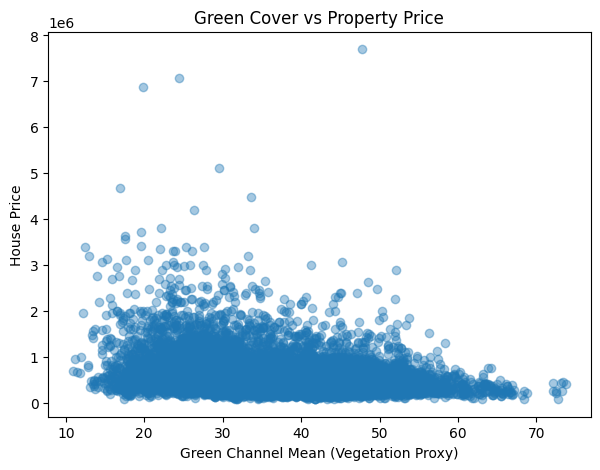

In [21]:
df = df.rename(columns={"price_x": "price"})
plt.figure(figsize=(7,5))
plt.scatter(df["g_mean"], df["price"], alpha=0.4)
plt.xlabel("Green Channel Mean (Vegetation Proxy)")
plt.ylabel("House Price")
plt.title("Green Cover vs Property Price")
plt.show()


### NDVI PROXY vs PRICE

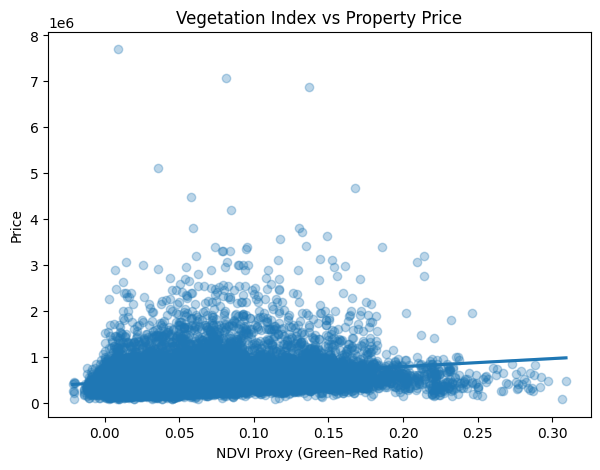

In [22]:
import seaborn as sns

df = df.rename(columns={"price_x": "price"})
plt.figure(figsize=(7,5))
sns.regplot(x=df["ndvi_proxy"], y=df["price"], scatter_kws={"alpha":0.3})
plt.xlabel("NDVI Proxy (Green–Red Ratio)")
plt.ylabel("Price")
plt.title("Vegetation Index vs Property Price")
plt.show()


### IMAGE FEATURES CORRELATION HEATMAP

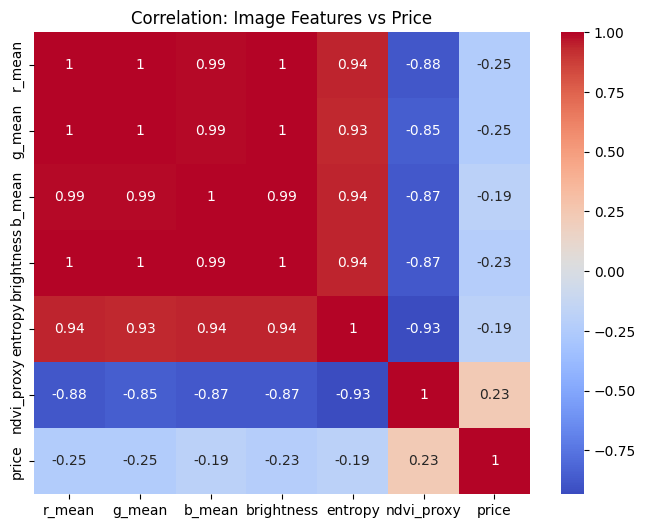

In [23]:
features = ["r_mean", "g_mean", "b_mean", "brightness", "entropy", "ndvi_proxy"]

plt.figure(figsize=(8,6))
sns.heatmap(df[features + ["price"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation: Image Features vs Price")
plt.show()
